# Crude oil price prediction using LSTM

### importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing dataset
1.Since data is in form of excel file we have to use pandas read_excel to load the data
2.After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row
3.Check whether any null values are there or not. if it is present then following can be done, a.Imputing data using Imputation method in sklearn b.Filling NaN values with mean, median and mode using fillna() method
4.Describe data --> which can give statistical analysis

In [106]:
data=pd.read_excel(r"D:\ML_training may 2020\Projects_50\Crude_oil_price_prediction\dataset\Crude Oil Prices Daily.xlsx")

In [107]:
data.head()

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [108]:
data.tail()

,Date,Closing Value
8218,2018-07-03,74.19
8219,2018-07-04,NaN
8220,2018-07-05,73.05
8221,2018-07-06,73.78
8222,2018-07-09,73.93


In [109]:
data.describe()

,Closing Value
count,8216.000000
mean,43.492139
std,29.616804
min,10.250000
25%,19.577500
50%,29.610000
75%,63.402500
max,145.310000


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8223 entries, 0 to 8222
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           8223 non-null   datetime64[ns]
 1   Closing Value  8216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.6 KB


# Data Preprocessing

## Checking or null values

In [111]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [112]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [113]:
data.dropna(axis=0,inplace=True)

In [114]:
data.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [115]:
data.shape

(8216, 2)

In [104]:
import tensorflow as tf

In [73]:
tf.__version__

'2.2.0'

In [74]:
import keras

In [75]:
keras.__version__

'2.4.3'

### Selecting Closing value column for prediction

In [116]:
data_oil=data.reset_index()['Closing Value']

In [117]:
data_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

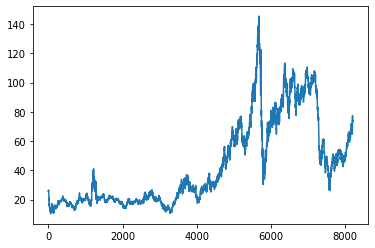

In [118]:
plt.plot(data_oil)

In [119]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [120]:
#Featuring Scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data_oil=scaler.fit_transform(np.array(data_oil).reshape(-1,1))

In [121]:
print(data_oil)

[[0.11335703]
 [0.11661484]
 [0.12053902]
 ...
 [0.46497853]
 [0.47038353]
 [0.47149415]]


### splitting dataset into train and test split

In [122]:

training_size=int(len(data_oil)*0.65)
test_size=len(data_oil)-training_size
train_data,test_data=data_oil[0:training_size,:],data_oil[training_size:len(data_oil),:1]


In [123]:
training_size,test_size


(5340, 2876)

In [124]:
train_data

array([[0.11335703],
       [0.11661484],
       [0.12053902],
       ...,
       [0.37916482],
       [0.38153413],
       [0.38294092]])

In [125]:
train_data.shape

(5340, 1)

In [126]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [127]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [128]:
print(X_train.shape), print(y_train.shape)

(5329, 10)
(5329,)


(None, None)

In [129]:
print(X_test.shape), print(ytest.shape)

(2865, 10)
(2865,)


(None, None)

In [130]:
X_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.36731823, 0.35176958, 0.36080261, ..., 0.36391234, 0.37042796,
        0.37042796],
       [0.35176958, 0.36080261, 0.35354657, ..., 0.37042796, 0.37042796,
        0.37879461],
       [0.36080261, 0.35354657, 0.35295424, ..., 0.37042796, 0.37879461,
        0.37916482]])

In [131]:
y_train

array([0.10165852, 0.09906708, 0.08203761, ..., 0.37879461, 0.37916482,
       0.38153413])

In [132]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Create the Stacked LSTM model

In [133]:
#tensorflow :open source used for both ML and DL for computation
from tensorflow.keras.models import Sequential#it is a plain stack of layers
from tensorflow.keras.layers import Dense#Dense layer is the regular deeply connected neural network layer
from tensorflow.keras.layers import LSTM #Long Short Trem Memory

In [30]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Training the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
84/84 [==============================] - 7s 83ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 2/50
84/84 [==============================] - 3s 40ms/step - loss: 1.2382e-04 - val_loss: 8.7243e-04
Epoch 3/50
84/84 [==============================] - 3s 36ms/step - loss: 1.1925e-04 - val_loss: 7.7329e-04
Epoch 4/50
84/84 [==============================] - 3s 32ms/step - loss: 1.2422e-04 - val_loss: 8.2006e-04
Epoch 5/50
84/84 [==============================] - 2s 29ms/step - loss: 1.2069e-04 - val_loss: 8.1166e-04
Epoch 6/50
84/84 [==============================] - 3s 31ms/step - loss: 1.1933e-04 - val_loss: 9.8186e-04
Epoch 7/50
84/84 [==============================] - 3s 30ms/step - loss: 1.1575e-04 - val_loss: 7.4925e-04
Epoch 8/50
84/84 [==============================] - 2s 29ms/step - loss: 1.2292e-04 - val_loss: 0.0010
Epoch 9/50
84/84 [==============================] - 2s 30ms/step - loss: 1.1673e-04 - val_loss: 7.2389e-04
Epoch 10/50
84/84 [==============================

In [34]:
## Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [35]:

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### model evaluation

In [36]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

28.804182105455187

In [37]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

76.34785179753273

## Predict the train and test data and plot the output

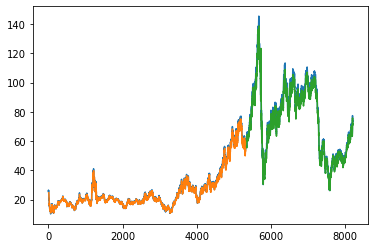

In [38]:
### Plotting 
# shift train predictions for plotting
look_back=10
trainPredictPlot = np.empty_like(data_oil)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_oil)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_oil)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_oil))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [39]:
model.save("crude_oil.h5")

In [ ]:
#prediction for next 10 days

In [40]:
len(test_data)

2876

In [41]:
x_input=test_data[2866:].reshape(1,-1)
x_input.shape

(1, 10)

In [42]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [43]:
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [44]:
len(temp_input)

10

### Predict the future 10 days and plot the graph

In [45]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=10
i=0
while(i<10):
    
    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)

[0.45856044]
11
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.45856044]
1 day output [[0.44484875]]
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.45856044 0.44484875]
2 day output [[0.43000898]]
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.45856044 0.44484875 0.43000898]
3 day output [[0.4157903]]
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.45856044 0.44484875 0.43000898 0.41579029]
4 day output [[0.40325096]]
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.45856044
 0.44484875 0.43000898 0.41579029 0.40325096]
5 day output [[0.39260027]]
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.45856044 0.44484875
 0.43000898 0.41579029 0.40325096 0.39260027]
6 day output [[0.383632]]
7 day input [0.46497853 0.47038353 0.47149415 0.45856044 0.44484875 0

In [46]:
day_new=np.arange(1,11)
day_pred=np.arange(11,21)

In [47]:
len(data_oil)

8216

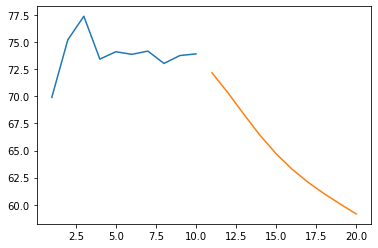

In [48]:
plt.plot(day_new,scaler.inverse_transform(data_oil[8206:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

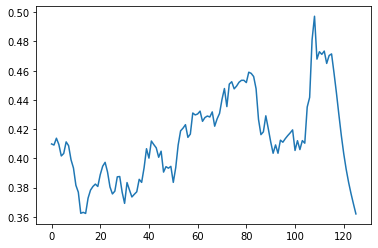

In [49]:
df3=data_oil.tolist()
df3.extend(lst_output)
plt.plot(df3[8100:])

In [50]:
df3=scaler.inverse_transform(df3).tolist()

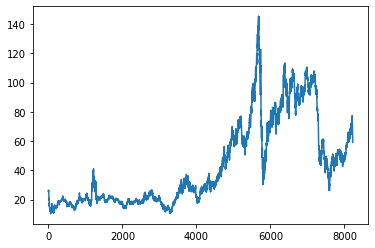

In [51]:
plt.plot(df3)

In [134]:
import jupyterthemes

In [135]:
!jt -r

Reset css and font defaults in:
C:\Users\Tulasi\.jupyter\custom &
C:\Users\Tulasi\AppData\Roaming\jupyter\nbextensions
